# Self supervised learning


## Library imports

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader
#from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageFile
import random
import torch
import torch.nn as nn
import torch.nn.init as init
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch import optim
from sklearn.metrics import confusion_matrix, classification_report


## Data preparation

###
The show_images function displays a batch of images from a DataLoader, allowing to quickly visualize the dataset

In [ ]:
def show_images(dataloader, num_images=6, num_channels=3, normalize=False):
    images, labels = next(iter(dataloader))  # (batch_size, C, H, W)

    # Adapt the numbre if the batchis smaller
    num_images = min(num_images, images.shape[0])

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.5, 2.5))

    for i in range(num_images):
        image = images[i].numpy()  # (C, H, W)

       
        if normalize:
            image = image * 0.5 + 0.5  

        image = np.clip(image, 0, 1)

        if num_channels == 1:
            image = image.squeeze(0)
            axes[i].imshow(image, cmap='gray')
        else:
            image = np.transpose(image, (1, 2, 0))  # (H, W, C)
            axes[i].imshow(image)
        class_name = train_dataset.classes[labels[i]]
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

The **ATRIER** directory contains **2333 unlabeled images**.  We will train several **self-supervised pretext tasks** on this dataset to learn visual features and then perform **fine-tuning** using the labeled dataset.

In [ ]:
from PIL import Image
import os

# Base directory
data_dir = "ATRIER"

# List of non-RGB images
non_rgb_images = []

# Traverse subfolders/classes
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tif', '.tiff')):
                try:
                    with Image.open(file_path) as img:
                        if img.mode != "RGB":
                            non_rgb_images.append((file_path, img.mode))
                except Exception as e:
                    print(f"Error with {file_path} : {e}")

# Display results
print(f"\n🧾 {len(non_rgb_images)} non-RGB image(s) found:")
for path, mode in non_rgb_images:
    print(f"{path} (mode: {mode})")



🧾 113 image(s) non-RGB found:
ATRIER/Oral Cancer photos/474.jpeg (mode : P)
ATRIER/Oral Cancer photos/dataset_mouth-photo-3.png (mode : RGBA)
ATRIER/Oral Cancer photos/dataset_oral-cancer-treatment-500x500.png (mode : RGBA)
ATRIER/Oral Cancer photos/dataset_Tongue-cancer-symptoms.png (mode : P)
ATRIER/Oral Cancer photos/497.jpeg (mode : RGBA)
ATRIER/Oral Cancer photos/Screenshot 2020-03-16 at 10.47.50 AM.png (mode : RGBA)
ATRIER/Oral Cancer photos/oralcancer1.png (mode : P)
ATRIER/Oral Cancer photos/S9.png (mode : RGBA)
ATRIER/Oral Cancer photos/Tongue-cancer-symptoms.png (mode : P)
ATRIER/Oral Cancer photos/495.jpeg (mode : RGBA)
ATRIER/Oral Cancer photos/S15.png (mode : RGBA)
ATRIER/Oral Cancer photos/S14.png (mode : RGBA)
ATRIER/Oral Cancer photos/mouth-photo-4.png (mode : RGBA)
ATRIER/Oral Cancer photos/498.jpeg (mode : RGBA)
ATRIER/Oral Cancer photos/S12.png (mode : RGBA)
ATRIER/Oral Cancer photos/493.jpeg (mode : RGBA)
ATRIER/Oral Cancer photos/499.jpeg (mode : RGBA)
ATRIER/Oral

In [ ]:
# Custom ImageFolder that converts all images to RGB
non_empty_classes = [
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d)) and
       len(os.listdir(os.path.join(data_dir, d))) > 0
]


# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Filter only non-empty folders
        classes = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d)) and len(os.listdir(os.path.join(directory, d))) > 0
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]

        try:
            img = Image.open(path)
        except (OSError, ValueError):
            # If the image is corrupted → pick a random other image
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        # Handle images in mode P or RGBA
        if img.mode == "P":
            img = img.convert("RGBA")

        if img.mode == "RGBA":
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])  # alpha channel
            img = background
        elif img.mode != "RGB":
            img = img.convert("RGB")

        # Apply transformations (ToTensor, etc.)
        if self.transform is not None:
            img = self.transform(img)

        return img, target


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),

    # Geometric augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(225, scale=(0.9, 1.0)),

    # Slight lighting augmentations
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    # Mild blurring
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),

    # Note: transforms.ToTensor() is commented out because the puzzle model expects an image, not a tensor

    # Normalization (required for CNNs)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Create dataset and data loader
train_dataset = FilteredImageFolder(root=data_dir, transform=None)
data_loader_train = DataLoader(train_dataset, batch_size=8, shuffle=True)


'""\n# Fonction de collation personnalisée\ndef jigsaw_collate_fn(batch):\n\n    #Empêche la collation par défaut de convertir les images PIL en tenseurs.\n    #Elle sépare le lot d\'images PIL (X) des étiquettes (Y).\n\n    # \'batch\' est une liste de tuples (image_PIL, target_label)\n    # Transposition : images = [img1, img2, ...], targets = [y1, y2, ...]\n    images, targets = zip(*batch)\n\n    # targets doit être converti en tenseur pour PyTorch, mais les images restent des objets PIL\n    targets = default_collate(targets)\n\n    return list(images), targets # Renvoyer les images sous forme de liste PIL\n\n\n# Création du DataLoader (dans la cellule du code 57)\ntrain_dataset = FilteredImageFolder(root=data_dir, transform=None)\ndata_loader_train = DataLoader(\n    train_dataset,\n    batch_size=128,\n    shuffle=True,\n    # AJOUTER CETTE LIGNE :\n    collate_fn=jigsaw_collate_fn\n)\n#show_images(data_loader_train, num_images=10, num_channels=3)\n'

## Shared architecture

In [ ]:
#  Define the encoder architecture
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            #nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

#  Define the decoder architecture
class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=128):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self,x):
        return self.decoder(x)
    

## Training function

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_ssl_model(model,
                    train_loader,

                    criterion,
                    optimizer,
                    device=device,
                    epochs=10):
    train_losses = []
    epochs_list = np.arange(1,epochs + 1, 1 )
    for epoch in range(epochs):
        print(epoch)
        model.to(device)
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
          #print
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")
        

    plt.figure(figsize=(7,5))
    plt.plot( epochs_list,train_losses, marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model.encoder


## Pretxt 1 : Colorization

### 1. Model

In [15]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(in_channels=1, latent_dim=latent_dim)  # Input grayscale
        self.decoder = Decoder(out_channels=3, latent_dim=latent_dim)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

### 2. Training

0
Epoch 1/50, Train Loss: 0.2292
1
Epoch 2/50, Train Loss: 0.1673
2
Epoch 3/50, Train Loss: 0.1627
3
Epoch 4/50, Train Loss: 0.1609
4
Epoch 5/50, Train Loss: 0.1589
5
Epoch 6/50, Train Loss: 0.1575
6
Epoch 7/50, Train Loss: 0.1569
7
Epoch 8/50, Train Loss: 0.1560
8
Epoch 9/50, Train Loss: 0.1553
9
Epoch 10/50, Train Loss: 0.1551
10
Epoch 11/50, Train Loss: 0.1545
11
Epoch 12/50, Train Loss: 0.1543
12
Epoch 13/50, Train Loss: 0.1545
13
Epoch 14/50, Train Loss: 0.1537
14
Epoch 15/50, Train Loss: 0.1536
15
Epoch 16/50, Train Loss: 0.1530
16
Epoch 17/50, Train Loss: 0.1529
17
Epoch 18/50, Train Loss: 0.1528
18
Epoch 19/50, Train Loss: 0.1529
19
Epoch 20/50, Train Loss: 0.1526
20
Epoch 21/50, Train Loss: 0.1518
21
Epoch 22/50, Train Loss: 0.1522
22
Epoch 23/50, Train Loss: 0.1516
23
Epoch 24/50, Train Loss: 0.1512
24
Epoch 25/50, Train Loss: 0.1513
25
Epoch 26/50, Train Loss: 0.1508
26
Epoch 27/50, Train Loss: 0.1508
27
Epoch 28/50, Train Loss: 0.1504
28
Epoch 29/50, Train Loss: 0.1507
29
E

/tmp/ipykernel_4130/4116463149.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


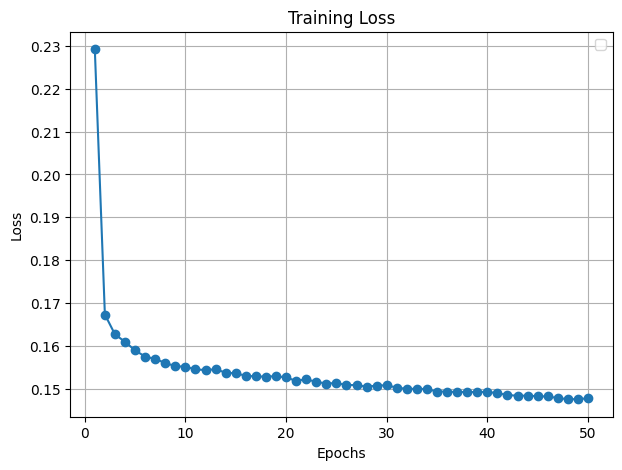

In [33]:
# Define a transform for the Colorization pretext task
# This transform should include ToTensor and Normalize for RGB images.
# The Encoder in ColorizationModel expects 32x32 input, so resize accordingly.

colorization_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Encoder expects 32x32 input
    #transforms.Grayscale(num_output_channels=1), # Convert to grayscale (1 channel)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

# Create a new dataset and dataloader for the colorization task
# Use the existing data_dir from the notebook state.
colorization_dataset = FilteredImageFolder(root=data_dir, transform=colorization_transform)
data_loader_colorization = DataLoader(colorization_dataset, batch_size=128, shuffle=True)

colorization_model = ColorizationModel(300)# Instantiate the colorization model
colorization_encoder = train_ssl_model(colorization_model,
                    train_loader=data_loader_colorization, # Use the new DataLoader
                    criterion=nn.MSELoss(),
                    optimizer=optim.Adam(colorization_model.parameters(), lr=0.001),
                    device=device,
                    epochs=50)

### 3. Visualize colorization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


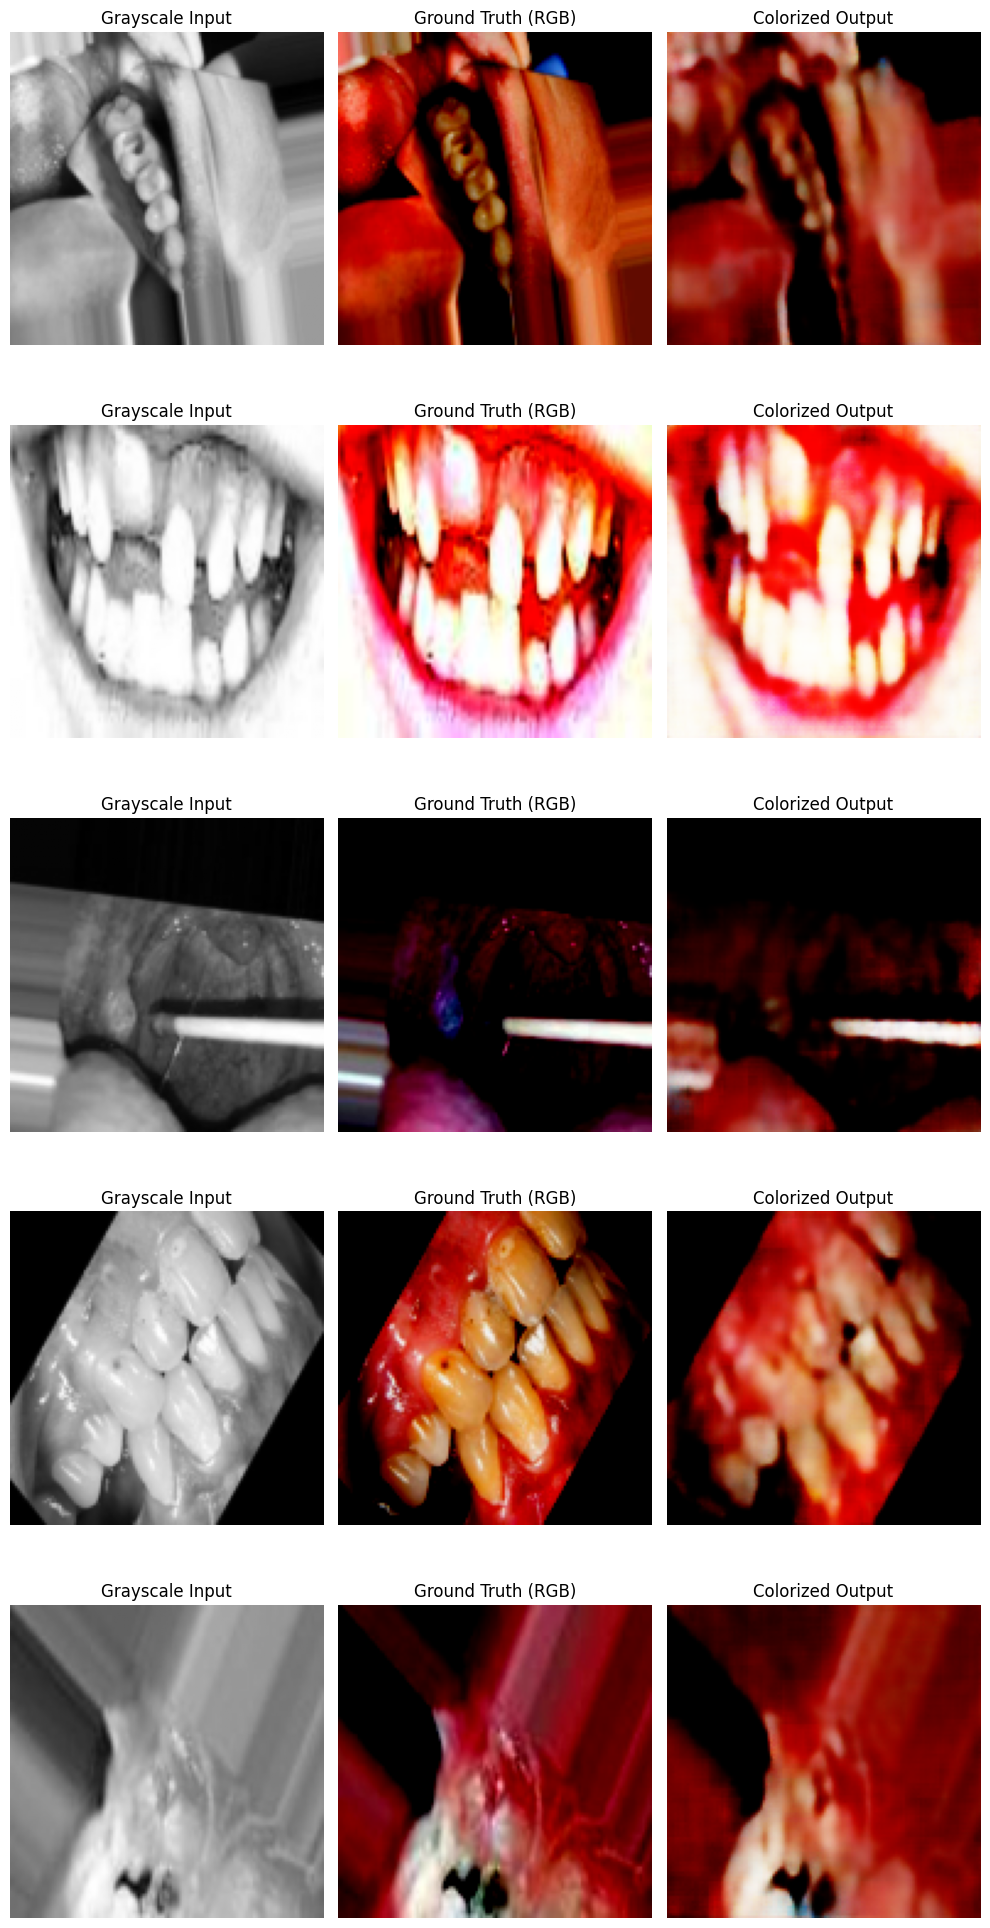

In [34]:
import random

# Visualize colorization on random test images

def visualize_reconstructions(model, data_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Convert the DataLoader to a list to randomly sample images
    dataset = list(data_loader.dataset)

    # Randomly select `num_images` images from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    random_images = [dataset[i][0] for i in random_indices]  # Extract only the images, ignoring labels

    # Stack the images into a batch
    images = torch.stack(random_images)

    # Move images to the specified device
    images = images.to(device)
    
    # Run the grayscale images through the colorization model
    with torch.no_grad():
        reconstructed_images, perturbed_images = model(images)
    
    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()
    perturbed_images = perturbed_images.cpu()
    
    # Plot the grayscale, ground truth, and colorized images
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 4))
    for i in range(num_images):
        # Grayscale input
        axes[i, 0].imshow(perturbed_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title("Grayscale Input")
        axes[i, 0].axis('off')
        
        # Ground truth (original RGB image)
        axes[i, 1].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Ground Truth (RGB)")
        axes[i, 1].axis('off')
        
        # Colorized output from the model
        axes[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0))
        axes[i, 2].set_title("Colorized Output")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize colorization on random test images
visualize_reconstructions(colorization_model, data_loader_colorization, device)

## Pretxt 2: Inpainting


### 1. Model

In [ ]:
class InpaintingModel(nn.Module):
    # : Implement the __init__ method
    def __init__(self, latent_dim =128, mask_size = 25):
        super().__init__()
        self.encoder = Encoder(in_channels=3, latent_dim=latent_dim)  # Input grayscale
        self.decoder = Decoder(out_channels=3, latent_dim=latent_dim)  # Predict RGB
        self.mask_size = mask_size

    # : Implement the forward method
    def forward(self,x):
        x_inpainting = self.apply_mask(x)
        x_encoder = self.encoder(x_inpainting)
        return self.decoder(x_encoder), x_inpainting

    # : Implement the apply_mask method
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)): # Loop over the batch size
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)# : Randomly sample the x coordinate of the upper left corner
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)# : Randomly sample the y coordinate of the upper left corner
            # : Apply the mask to the image
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

### 2. Training

0
Epoch 1/30, Train Loss: 0.2522
1
Epoch 2/30, Train Loss: 0.1966
2
Epoch 3/30, Train Loss: 0.1907
3
Epoch 4/30, Train Loss: 0.1882
4
Epoch 5/30, Train Loss: 0.1863
5
Epoch 6/30, Train Loss: 0.1851
6
Epoch 7/30, Train Loss: 0.1842
7
Epoch 8/30, Train Loss: 0.1830
8
Epoch 9/30, Train Loss: 0.1825
9
Epoch 10/30, Train Loss: 0.1822
10
Epoch 11/30, Train Loss: 0.1825
11
Epoch 12/30, Train Loss: 0.1813
12
Epoch 13/30, Train Loss: 0.1818
13
Epoch 14/30, Train Loss: 0.1809
14
Epoch 15/30, Train Loss: 0.1811
15
Epoch 16/30, Train Loss: 0.1808
16
Epoch 17/30, Train Loss: 0.1809
17
Epoch 18/30, Train Loss: 0.1813
18
Epoch 19/30, Train Loss: 0.1806
19
Epoch 20/30, Train Loss: 0.1807
20
Epoch 21/30, Train Loss: 0.1806
21
Epoch 22/30, Train Loss: 0.1803
22
Epoch 23/30, Train Loss: 0.1803
23
Epoch 24/30, Train Loss: 0.1803
24
Epoch 25/30, Train Loss: 0.1801
25
Epoch 26/30, Train Loss: 0.1800
26
Epoch 27/30, Train Loss: 0.1799
27
Epoch 28/30, Train Loss: 0.1801
28
Epoch 29/30, Train Loss: 0.1800
29
E

/tmp/ipykernel_4130/4116463149.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


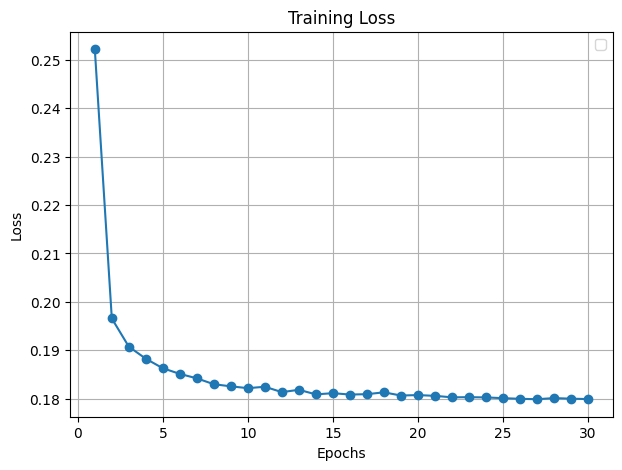

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Encoder expects 32x32 input
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(128, scale=(0.9, 1.0)),
    #transforms.Grayscale(num_output_channels=1), # Convert to grayscale (1 channel)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])
dataset = FilteredImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
#show_images(data_loader_colorization, num_images=10, num_channels=3)
# TODO: Pre-train the encoder using SVHN dataset (Note: using current dataset for colorization)

inpainting_model = InpaintingModel(300,30)# TODO: Instantiate the colorization model
inpainting_encoder = train_ssl_model(inpainting_model, 
                    train_loader=data_loader, 
                    criterion=nn.MSELoss(),
                    optimizer=optim.Adam(inpainting_model.parameters(), lr=0.001),
                    device=device,
                    epochs=30)

### 3. Visualize Inpainting

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid r

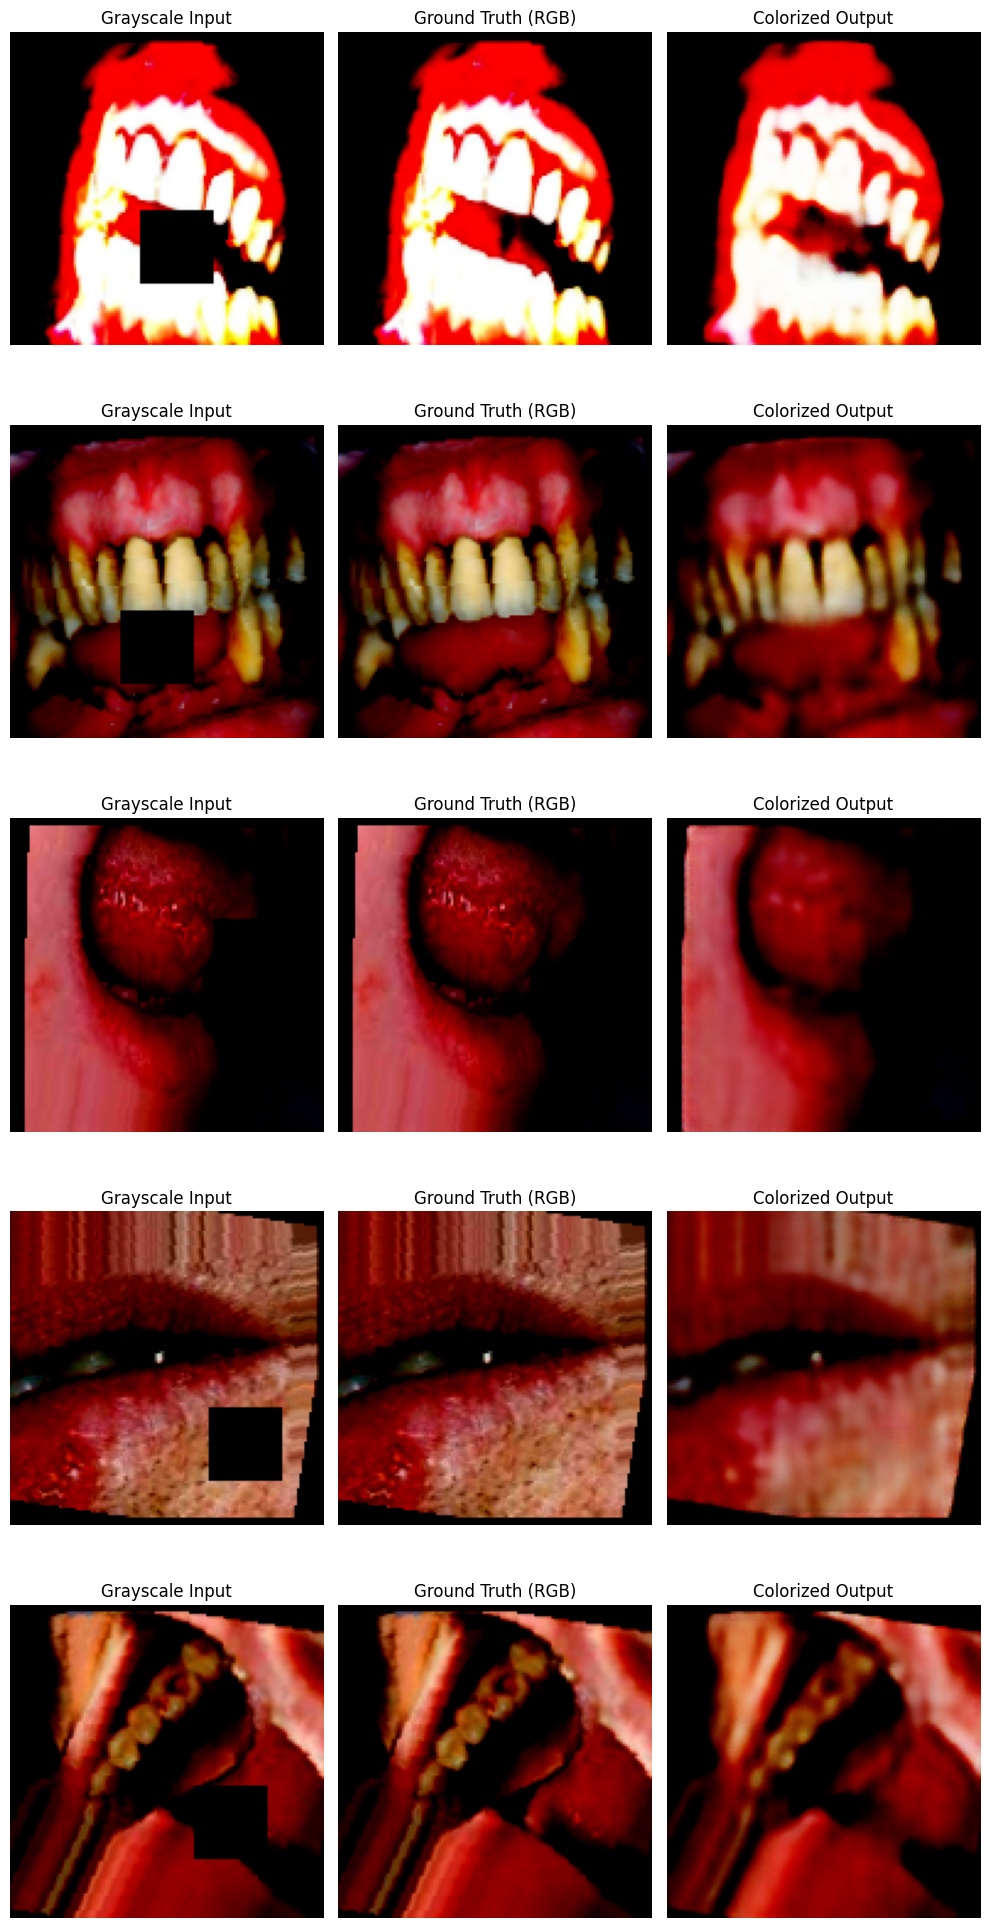

In [58]:
visualize_reconstructions(inpainting_model, data_loader, device)

## Pretext 3: Masked Autoencoder

### 1. Model

In [ ]:
class MaskedAutoencoderModel(nn.Module):
    #: Implement the __init__ method
    def __init__(self, latent_dim = 300, fraction_p = 20):
        super().__init__()
        self.encoder = Encoder(in_channels=3, latent_dim=latent_dim)
        self.decoder = Decoder(out_channels=3, latent_dim=latent_dim)
        self.mask_ratio = fraction_p

    #  Implement the forward method
    def forward(self,x):
        x_masked = self.apply_mask(x)
        x_encode = self.encoder(x_masked)
        return self.decoder(x_encode), x_masked
    
    # Implement the apply_mask method
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)# create a random mask with the right average number of pixels masked
        x_masked[mask] = 0
        return x_masked

### 2. Training

0
Epoch 1/30, Train Loss: 0.2800
1
Epoch 2/30, Train Loss: 0.1965
2
Epoch 3/30, Train Loss: 0.1904
3
Epoch 4/30, Train Loss: 0.1873
4
Epoch 5/30, Train Loss: 0.1857
5
Epoch 6/30, Train Loss: 0.1843
6
Epoch 7/30, Train Loss: 0.1832
7
Epoch 8/30, Train Loss: 0.1828
8
Epoch 9/30, Train Loss: 0.1817
9
Epoch 10/30, Train Loss: 0.1814
10
Epoch 11/30, Train Loss: 0.1812
11
Epoch 12/30, Train Loss: 0.1806
12
Epoch 13/30, Train Loss: 0.1806
13
Epoch 14/30, Train Loss: 0.1807
14
Epoch 15/30, Train Loss: 0.1801
15
Epoch 16/30, Train Loss: 0.1800
16
Epoch 17/30, Train Loss: 0.1796
17
Epoch 18/30, Train Loss: 0.1792
18
Epoch 19/30, Train Loss: 0.1793
19
Epoch 20/30, Train Loss: 0.1797
20
Epoch 21/30, Train Loss: 0.1790
21
Epoch 22/30, Train Loss: 0.1799
22
Epoch 23/30, Train Loss: 0.1789
23
Epoch 24/30, Train Loss: 0.1790
24
Epoch 25/30, Train Loss: 0.1789
25
Epoch 26/30, Train Loss: 0.1788
26
Epoch 27/30, Train Loss: 0.1787
27
Epoch 28/30, Train Loss: 0.1789
28
Epoch 29/30, Train Loss: 0.1787
29
E

/tmp/ipykernel_4130/4116463149.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


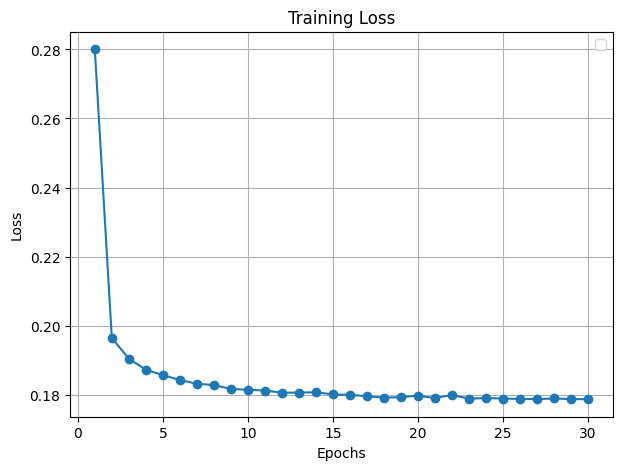

In [67]:
mae_model = MaskedAutoencoderModel(300, 1/5)# TODO: Instantiate the colorization model
mae_encoder = train_ssl_model(mae_model, 
                    train_loader=data_loader, 
                    criterion=nn.MSELoss(),
                    optimizer=optim.Adam(mae_model.parameters(), lr=0.001),
                    device=device,
                    epochs=30)

### 3. Visualise Masked Autoencoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

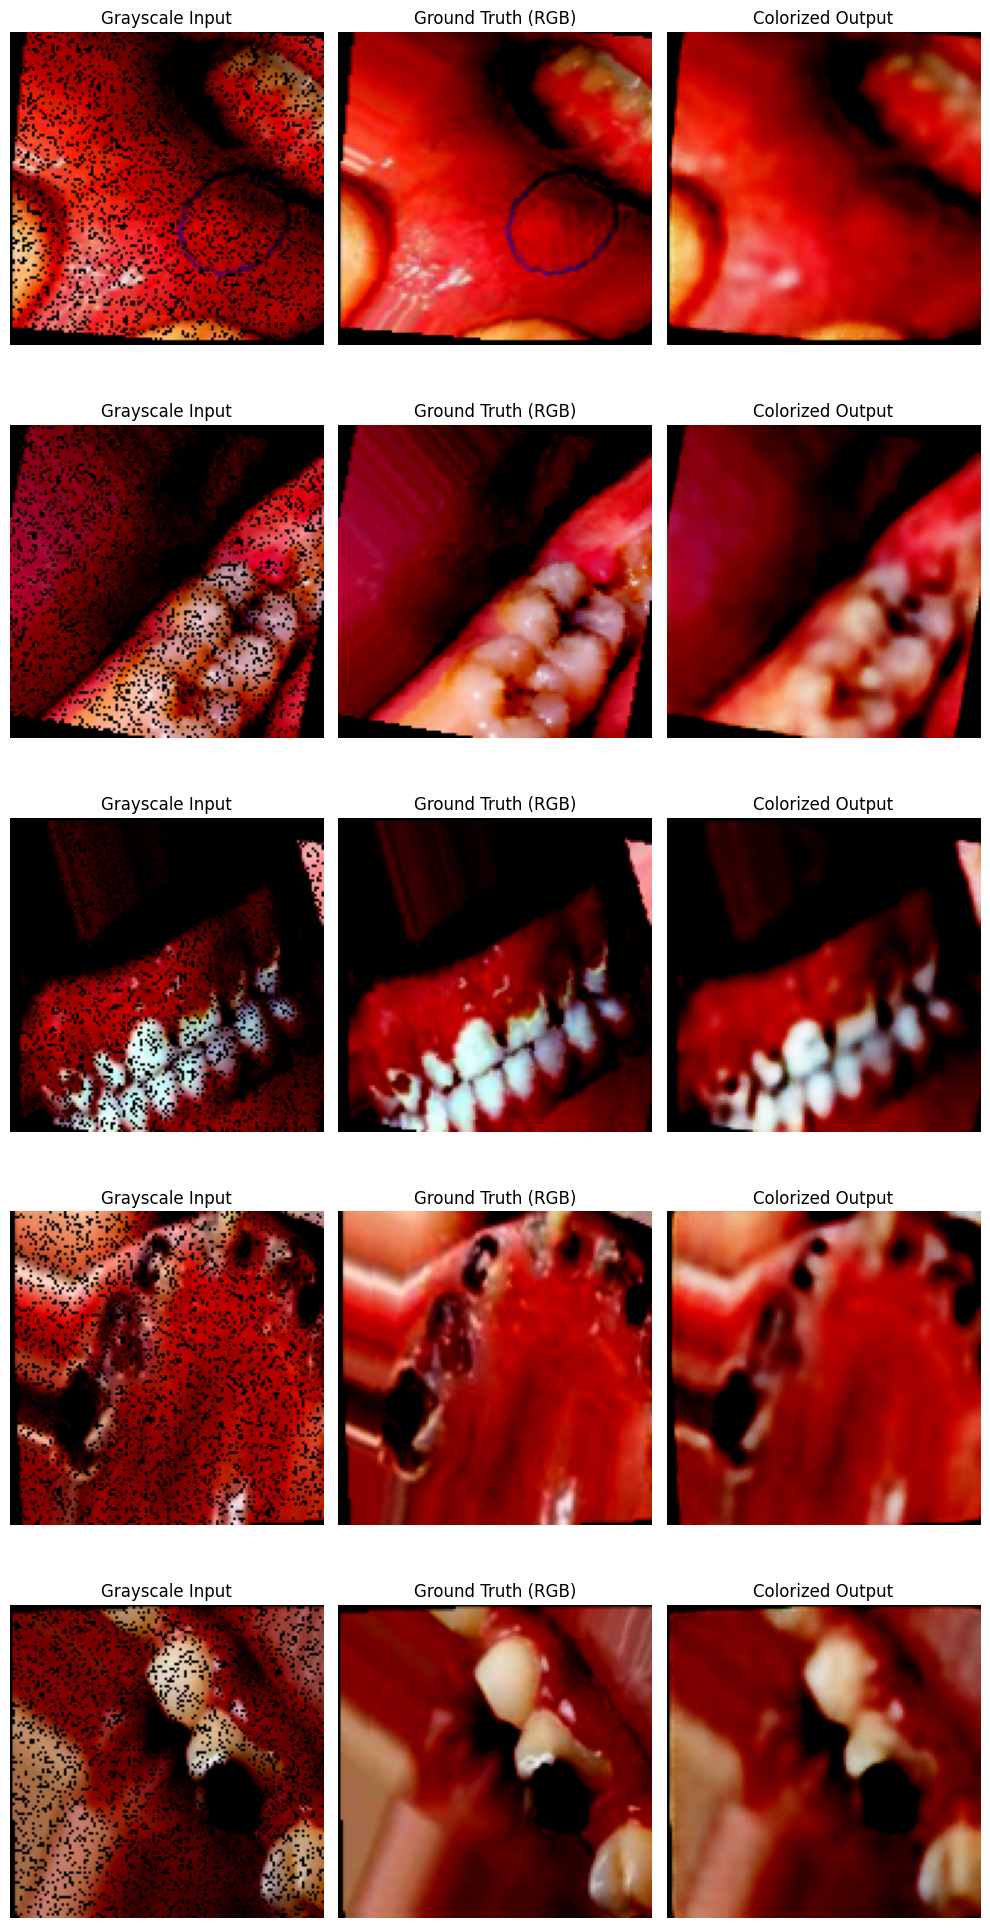

In [68]:
visualize_reconstructions(mae_model, data_loader, device)

## Classification

Now that our model has been trained on the pretext task, the encoder has learned the essential features.  For the downstream task, the decoder will be removed, and only the encoder will be kept and fine-tuned using the labeled dataset located in the directory "First_Trial. 


### 1. Classification data

The **colorization pretext task** accepts images in **grayscale**. However, for **inpainting** and the **MAE Autoencoder**, the images are processed differently.  

Therefore, **two separate transformations** are implemented:  

- **Transform 1:** Designed for the **colorization task**.  
- **Transform 2:** Designed for the **MAE Autoencoder** and **inpainting tasks**.


In [ ]:
# Adjust transform for classification to output 1-channel (grayscale) images,
# matching the pre-trained colorization encoder.
transform_classif = transforms.Compose([
    transforms.Resize((32, 32)), 

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)), # Adjusted crop size to 32
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),

    transforms.Grayscale(num_output_channels=1), # Convert to grayscale for the 1-channel encoder
    transforms.ToTensor(),

    # Normalize for 1 channel (grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

data_dir_classif = "First_Trial"
# Using data_dir from pretext task for consistency
dataset_classif = FilteredImageFolder(root=data_dir_classif, transform=transform_classif)
train_size = int(0.8 * len(dataset_classif))
test_size = int(0.1 * len(dataset_classif ))
val_size = len(dataset_classif )- train_size - test_size

train_dataset_classif , test_dataset, val_dataset = random_split(dataset_classif , [train_size, test_size, val_size])
data_loader_train_classif  = DataLoader(train_dataset_classif , batch_size=8, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=8, shuffle=True)
data_loader_val = DataLoader(val_dataset, batch_size=8, shuffle=True)


### 2. Model

In [39]:

class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder
        # The latent_dim from ColorizationModel was 300, and the encoder outputs 2x2 spatial features.
        # So, the flattened size is 300 * 2 * 2 = 1200.
        self.x_size = 300 * 2 * 2
        self.classif = nn.Sequential(
            nn.Linear(in_features=self.x_size, out_features=num_classes),
            # Removed Softmax: nn.CrossEntropyLoss expects raw logits, not probabilities.
            # Softmax is implicitly applied within CrossEntropyLoss.
        )

    def forward(self, x):
        x_encode = self.encoder(x)
        # Removed the problematic reassignment of self.x_size here.
        x_encode = x_encode.view(x_encode.size(0), -1)
        return self.classif(x_encode)


### 3. Fine tuning

In [ ]:
# Fine-tuning loop for classification
def fine_tune_classification(encoder, train_loader, test_loader, epochs=5):
    model = Classifier(encoder, num_classes=len(train_loader.dataset.dataset.classes)).to(device) # Get num_classes dynamically
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Freeze the encoder's weights as per fine-tuning common practice
    for param in encoder.parameters():
        param.requires_grad = False
    train_accuracy = []
    epochs_list = np.arange(1,epochs + 1, 1 )
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Images are already 1-channel grayscale due to the updated transform
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Compute accuracy
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        #epochs_list = np.arange(1, len(train_accuracy) +1)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {100 * correct / total:.2f}%")
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)
    plt.figure(figsize=(7,5))
    plt.plot( epochs_list, train_accuracy, marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model # Return the trained classifier model


"\n    # Evaluate on test set\n    model.eval()\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for images, labels in test_loader:\n            # Images are already 1-channel grayscale\n            images = images.to(device)\n            labels = labels.to(device)\n            output = model(images)\n            _, predicted = torch.max(output, 1)\n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n\n    print(f'Test Accuracy: {100 * correct / total:.2f}%')\n    "

### 4. Training

Epoch 1/50, Loss: 1.8583463555727249, Accuracy: 30.59%
Epoch 2/50, Loss: 1.7472036517583407, Accuracy: 35.54%
Epoch 3/50, Loss: 1.6202465638900414, Accuracy: 39.54%
Epoch 4/50, Loss: 1.575276361673306, Accuracy: 40.24%
Epoch 5/50, Loss: 1.5760663595814735, Accuracy: 41.47%
Epoch 6/50, Loss: 1.5141552321421794, Accuracy: 44.37%
Epoch 7/50, Loss: 1.5093811414180658, Accuracy: 43.92%
Epoch 8/50, Loss: 1.51866093750458, Accuracy: 43.53%
Epoch 9/50, Loss: 1.550040125541198, Accuracy: 43.79%
Epoch 10/50, Loss: 1.4460032872664623, Accuracy: 44.43%
Epoch 11/50, Loss: 1.479170207793896, Accuracy: 42.95%
Epoch 12/50, Loss: 1.44680922179459, Accuracy: 44.95%
Epoch 13/50, Loss: 1.4438771715530982, Accuracy: 45.14%
Epoch 14/50, Loss: 1.4630777957932786, Accuracy: 45.46%
Epoch 15/50, Loss: 1.4260371325871883, Accuracy: 45.07%
Epoch 16/50, Loss: 1.491628950070112, Accuracy: 44.43%
Epoch 17/50, Loss: 1.4437269072120007, Accuracy: 47.39%
Epoch 18/50, Loss: 1.4441341306918707, Accuracy: 45.59%
Epoch 19/

/tmp/ipykernel_4130/3088090413.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


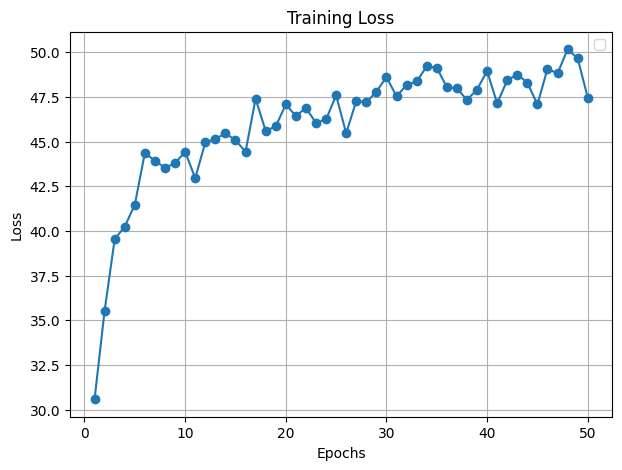

In [ ]:
# Pass the pre-trained encoder instance (colorization_encoder) to the fine-tuning function.
# The 'encoder_in_channels' argument is no longer needed as the data transform handles grayscale conversion.
classifier_model_colorization = fine_tune_classification(colorization_encoder, data_loader_train_classif , data_loader_test, epochs=50)
torch.save(classifier_model_colorization.state_dict(), "pretext_colorization.pth")

In [ ]:
# Pass the pre-trained encoder instance (colorization_encoder) to the fine-tuning function.
# The 'encoder_in_channels' argument is no longer needed as the data transform handles grayscale conversion.
classifier_model = fine_tune_classification(colorization_encoder, data_loader_train_classif , data_loader_test, epochs=50)
torch.save(classifier_model.state_dict(), "pretext_colorization.pth")


Epoch 1/50, Loss: 1.7409843739790793, Accuracy: 32.71%
Epoch 2/50, Loss: 1.6045036737735454, Accuracy: 40.12%
Epoch 3/50, Loss: 1.5546012001159863, Accuracy: 39.86%
Epoch 4/50, Loss: 1.51742080450058, Accuracy: 42.11%
Epoch 5/50, Loss: 1.5124606404549037, Accuracy: 43.85%
Epoch 6/50, Loss: 1.4858601781038137, Accuracy: 42.37%
Epoch 7/50, Loss: 1.4857672656957919, Accuracy: 43.40%
Epoch 8/50, Loss: 1.4555595073944483, Accuracy: 44.49%
Epoch 9/50, Loss: 1.4633569164153857, Accuracy: 42.95%
Epoch 10/50, Loss: 1.4481543119137104, Accuracy: 43.85%
Epoch 11/50, Loss: 1.41735177727846, Accuracy: 45.85%
Epoch 12/50, Loss: 1.3955253830322853, Accuracy: 46.30%
Epoch 13/50, Loss: 1.4197808653880388, Accuracy: 46.23%
Epoch 14/50, Loss: 1.3960722794899574, Accuracy: 47.33%
Epoch 15/50, Loss: 1.405066320223686, Accuracy: 45.65%
Epoch 16/50, Loss: 1.3850292707100893, Accuracy: 46.75%
Epoch 17/50, Loss: 1.3701576616901618, Accuracy: 47.71%
Epoch 18/50, Loss: 1.39213455976584, Accuracy: 47.13%
Epoch 19

In [ ]:

# Adjust transform for classification to output 1-channel (grayscale) images,
# matching the pre-trained colorization encoder.
transform2 = transforms.Compose([
    transforms.Resize((32, 32)), # Encoder expects 32x32 input - changed from 225, 225
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)), # Adjusted crop size to 32
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),

    #transforms.Grayscale(num_output_channels=1), # Convert to grayscale for the 1-channel encoder
    transforms.ToTensor(),

    # Normalize for 1 channel (grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

data_dir_classif = "First_Trial"
# Using data_dir from pretext task for consistency
dataset_classif2 = FilteredImageFolder(root=data_dir_classif, transform=transform2)
train_size = int(0.8 * len(dataset_classif))
test_size = int(0.1 * len(dataset_classif ))
val_size = len(dataset_classif )- train_size - test_size

train_dataset_classif2 , test_dataset2, val_dataset2 = random_split(dataset_classif2 , [train_size, test_size, val_size])
data_loader_train_classif2  = DataLoader(train_dataset_classif2 , batch_size=8, shuffle=True)
data_loader_test2 = DataLoader(test_dataset2, batch_size=8, shuffle=True)
data_loader_val2 = DataLoader(val_dataset2, batch_size=8, shuffle=True)

Epoch 1/40, Loss: 1.9047527288779234, Accuracy: 29.04%
Epoch 2/40, Loss: 1.7355936863483528, Accuracy: 33.93%
Epoch 3/40, Loss: 1.637707276374866, Accuracy: 37.28%
Epoch 4/40, Loss: 1.5930695133331494, Accuracy: 39.15%
Epoch 5/40, Loss: 1.5806908757258684, Accuracy: 41.08%
Epoch 6/40, Loss: 1.5684788074248877, Accuracy: 40.12%
Epoch 7/40, Loss: 1.552097885754819, Accuracy: 41.34%
Epoch 8/40, Loss: 1.5605399821049128, Accuracy: 41.66%
Epoch 9/40, Loss: 1.5747731123215114, Accuracy: 40.05%
Epoch 10/40, Loss: 1.4924906551837922, Accuracy: 42.37%
Epoch 11/40, Loss: 1.5670605993423707, Accuracy: 39.60%
Epoch 12/40, Loss: 1.524309186752026, Accuracy: 42.18%
Epoch 13/40, Loss: 1.5281959276932937, Accuracy: 43.01%
Epoch 14/40, Loss: 1.5164155522982279, Accuracy: 40.50%
Epoch 15/40, Loss: 1.5473806258959648, Accuracy: 43.59%
Epoch 16/40, Loss: 1.518164454973661, Accuracy: 41.85%
Epoch 17/40, Loss: 1.5249097298353147, Accuracy: 43.98%
Epoch 18/40, Loss: 1.5104377552484856, Accuracy: 42.63%
Epoch

/tmp/ipykernel_4130/3088090413.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


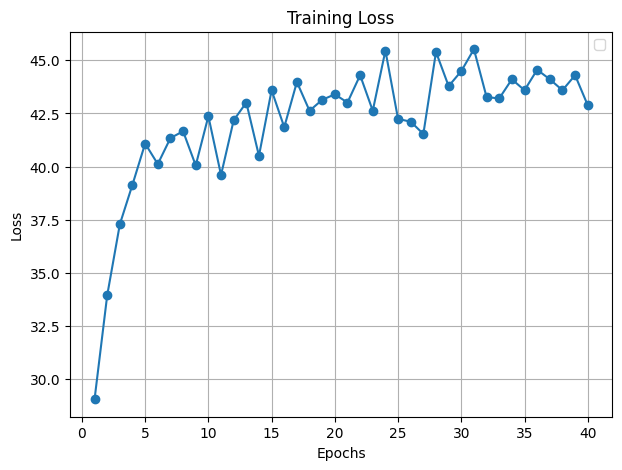

In [61]:

# 3. Fine-tune Masked Autoencoder model
classifier_model_inpainting = fine_tune_classification(inpainting_encoder, data_loader_train_classif2 , data_loader_test2, epochs=40)
torch.save(classifier_model_inpainting.state_dict(), "pretext_inpainting.pth")


Epoch 1/40, Loss: 2.4756088143739943, Accuracy: 27.43%
Epoch 2/40, Loss: 2.0153205261780665, Accuracy: 34.06%
Epoch 3/40, Loss: 2.022504565960322, Accuracy: 34.00%
Epoch 4/40, Loss: 2.0068984114206754, Accuracy: 36.57%
Epoch 5/40, Loss: 1.864325302380782, Accuracy: 38.51%
Epoch 6/40, Loss: 1.9433897657272143, Accuracy: 37.41%
Epoch 7/40, Loss: 1.934906366849557, Accuracy: 38.63%
Epoch 8/40, Loss: 1.9658228463087326, Accuracy: 38.57%
Epoch 9/40, Loss: 2.111661179554768, Accuracy: 36.32%
Epoch 10/40, Loss: 1.9551161270875197, Accuracy: 39.09%
Epoch 11/40, Loss: 1.9607506428009425, Accuracy: 37.54%
Epoch 12/40, Loss: 2.0099802589397697, Accuracy: 37.15%
Epoch 13/40, Loss: 1.7533635910075063, Accuracy: 41.92%
Epoch 14/40, Loss: 1.9279813185716286, Accuracy: 38.70%
Epoch 15/40, Loss: 1.9945313499524042, Accuracy: 39.47%
Epoch 16/40, Loss: 1.9544422819064213, Accuracy: 40.50%
Epoch 17/40, Loss: 2.0595774115660253, Accuracy: 38.83%
Epoch 18/40, Loss: 2.1176605838995712, Accuracy: 39.21%
Epoch

/tmp/ipykernel_4130/3088090413.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


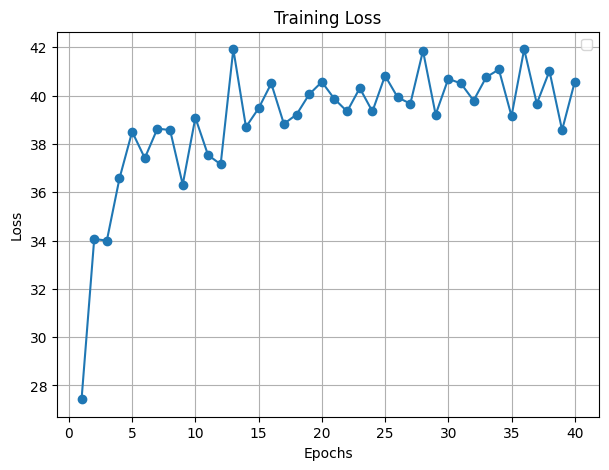

In [69]:

# 3. Fine-tune Masked Autoencoder model
classifier_model_mae = fine_tune_classification(mae_encoder, data_loader_train_classif2 , data_loader_test2, epochs=40)
torch.save(classifier_model_mae.state_dict(), "pretext_mae.pth")


### a. Colorization

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

all_labels = []
all_preds = []
classifier_model.load_state_dict(torch.load("pretext.pth", map_location=device))

classifier_model.eval()
with torch.no_grad():
    for images, labels in data_loader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = classifier_model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
class_names = dataset_classif.classes
print("Classes :", class_names)


Classes : ['HERPES SIMPLEX ', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']



Test Accuracy : 47.94%

--- Classification Report---
                          precision    recall  f1-score   support

         HERPES SIMPLEX        1.00      0.23      0.38        13
            Leukoplakia        0.46      0.43      0.45        44
               Mucocele        0.33      0.10      0.15        10
             Oral Cancer       0.33      0.23      0.27        26
      Oral Lichen Planus       0.36      0.68      0.47        44
Oral Submucous Fibrosis        0.46      0.30      0.36        20
    Perioral_Dermatitis        0.83      0.71      0.77         7
           normal mucosa       0.88      0.77      0.82        30

                accuracy                           0.48       194
               macro avg       0.58      0.43      0.46       194
            weighted avg       0.53      0.48      0.47       194

Confusion Matrix :
 [[ 3  0  0  1  6  2  1  0]
 [ 0 19  1  2 19  2  0  1]
 [ 0  1  1  1  6  1  0  0]
 [ 0  5  0  6 14  1  0  0]
 [ 0  8  0  4 30  0  0 

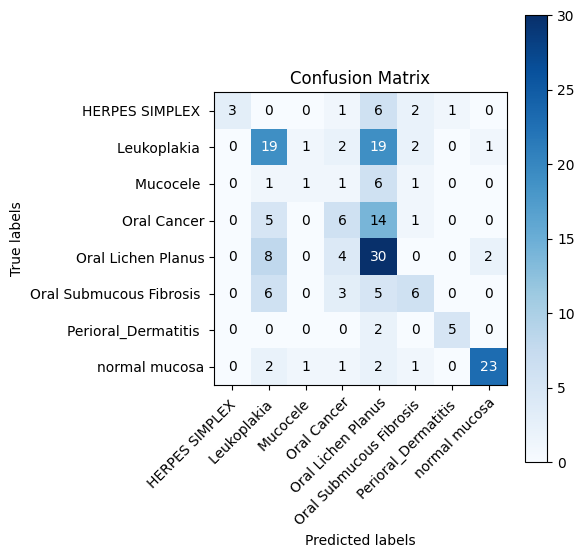

In [52]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy : {test_accuracy*100:.2f}%")

# 2. Afficher le Rapport de Classification (précision, rappel, F1-score par classe)
print("\n--- Classification Report---")
# La fonction classification_report prend le nom des classes en compte
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
print(report)


cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True labels',
    xlabel='Predicted labels',
    title='Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


###  `Test function`

In this section, we define the `Test` function, which performs the following tasks:

1. Loads a previously saved model from a file.
2. Tests the model on a labeled dataset.
3. Plots the confusion matrix to evaluate the model's performance.


In [49]:
def Test(file, classifier_model):
    all_labels = []
    all_preds = []
    classifier_model.load_state_dict(torch.load(file, map_location=device))

    classifier_model.eval()
    with torch.no_grad():
        for images, labels in data_loader_test2:
            images = images.to(device)
            labels = labels.to(device)

            outputs = classifier_model(images)
            _, preds = torch.max(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    class_names = dataset_classif.classes
    print("Classes :", class_names)
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy : {test_accuracy*100:.2f}%")

    # 2. Afficher le Rapport de Classification (précision, rappel, F1-score par classe)
    print("\n--- Classification Report---")
    # La fonction classification_report prend le nom des classes en compte
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print(report)


    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix :\n", cm)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='True labels',
        xlabel='Predicted labels',
        title='Confusion Matrix'
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # annotations dans chaque case
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()

### b. Inpainting

Classes : ['HERPES SIMPLEX ', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

Test Accuracy : 45.36%

--- Classification Report---
                          precision    recall  f1-score   support

         HERPES SIMPLEX        0.44      0.44      0.44         9
            Leukoplakia        0.58      0.55      0.56        53
               Mucocele        0.00      0.00      0.00        11
             Oral Cancer       0.00      0.00      0.00        24
      Oral Lichen Planus       0.30      0.54      0.39        35
Oral Submucous Fibrosis        0.31      0.42      0.36        24
    Perioral_Dermatitis        0.64      0.70      0.67        10
           normal mucosa       0.83      0.68      0.75        28

                accuracy                           0.45       194
               macro avg       0.39      0.42      0.40       194
            weighted avg       0.42      0.45      0.

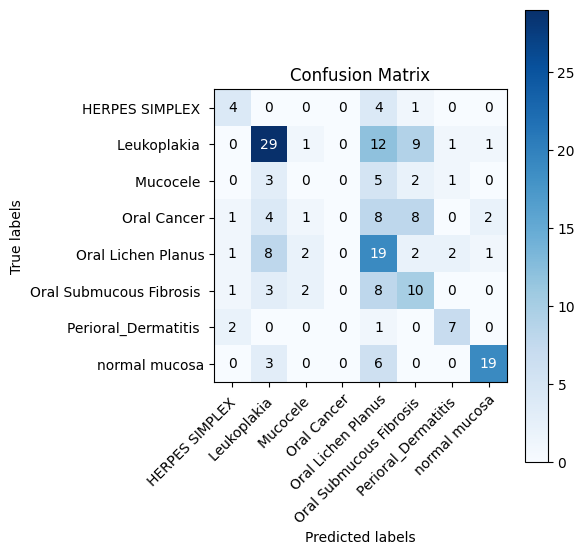

In [65]:
Test(file = "pretext_inpainting.pth", classifier_model = classifier_model_inpainting)

### c. MAE Autoencoder

Classes : ['HERPES SIMPLEX ', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

Test Accuracy : 46.91%

--- Classification Report---
                          precision    recall  f1-score   support

         HERPES SIMPLEX        0.00      0.00      0.00         9
            Leukoplakia        0.40      0.91      0.56        53
               Mucocele        0.00      0.00      0.00        11
             Oral Cancer       0.00      0.00      0.00        24
      Oral Lichen Planus       0.58      0.31      0.41        35
Oral Submucous Fibrosis        0.00      0.00      0.00        24
    Perioral_Dermatitis        0.78      0.70      0.74        10
           normal mucosa       0.61      0.89      0.72        28

                accuracy                           0.47       194
               macro avg       0.30      0.35      0.30       194
            weighted avg       0.34      0.47      0.

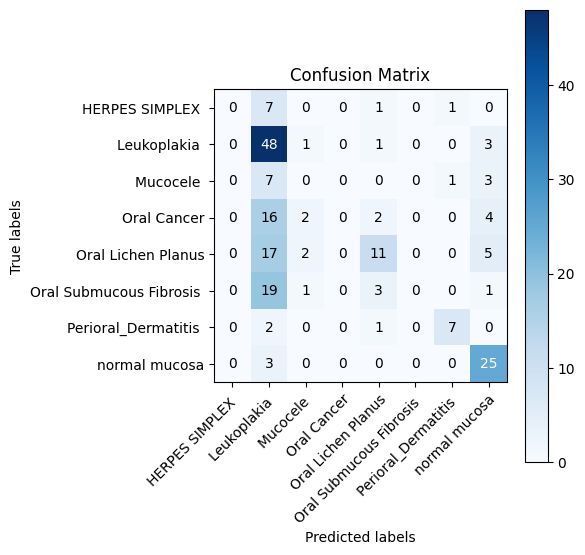

In [73]:
Test(file = "pretext_mae.pth", classifier_model = classifier_model_mae)